In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

def smooth(x, y, num=1000, window=100):
    from scipy.interpolate import interp1d
    from scipy.ndimage import uniform_filter1d
    x = np.asarray(x); y = np.asarray(y)
    # Step 1: interpolate to uniform y
    y_uniform = np.linspace(y.min(), y.max(), num)
    f_interp = interp1d(y, x, kind='linear', fill_value='extrapolate')
    x_uniform = f_interp(y_uniform)
    # Step 2: smooth x on the uniform y grid
    x_smooth_uniform = uniform_filter1d(x_uniform, size=window)
    # Step 3: interpolate back to original y
    f_smooth = interp1d(y_uniform, x_smooth_uniform, kind='linear', fill_value='extrapolate')
    x_smooth = f_smooth(y)

    return x_smooth

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import calculate_eddy, dopioe, plot_ellipse, solve_w, calc_ow, normalize_matrix
from utils import dopioe_grid, moca, extract_transect_center, gaussian_vel_reconstruction, espra

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]

the_frontier_eddies

['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

In [2]:
def ESM_data_collector(eddy, day, r=50):
    
    df_data = pd.DataFrame(columns=['Eddy', 'Day', 'Method', 'xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'z', 'Depth'])
    
    day = f'T{day}'
    
    dic_eddy = sample_data[eddy]
    dic = dic_eddy[day]
    
    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    x0old_moc, y0old_moc = 0, 0
    x0old_dop, y0old_dop = 0, 0
    x0old_esp, y0old_esp = 0, 0
    
    moca_flag = 1
    dopioe_flag = 1
    esp_flag = 1
    
    for k in range(U.shape[-1]):
    
        u, v = U[:,:,k], V[:,:,k]
    
        # MOCA
        if moca_flag:
            dic_moc = extract_transect_center(u, v, X, Y, x0old_moc, y0old_moc, r)
            x1_moc, y1_moc, u1_moc, v1_moc, xx_moc = dic_moc['x1'], dic_moc['y1'], dic_moc['u1'], dic_moc['v1'], dic_moc['xx']
    
            l = x1_moc - x1_moc.min()
            VT, VN = u1_moc, v1_moc
            l0, r0, wmoca, Qmoca, Rcmoca, psi0moca = moca(l, VT, VN)
            x0moca, y0moca = x1_moc.min() + l0, y1_moc[0] + r0
            if not np.isnan(x0moca):
    
                if np.hypot(x0moca - x0old_moc, y0moca - y0old_moc) < 50:
                
                    df_data.loc[len(df_data)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'MOCA',
                        'xc': x0moca, 'yc': y0moca, 'w': wmoca,
                        'Q': Qmoca, 'Rc': Rcmoca, 'psi0': psi0moca,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_moc, y0old_moc = x0moca, y0moca
                else:
                    moca_flag = 0
            else:
                moca_flag = 0
        
        # DOPIOE
        if dopioe_flag:
            dic_dop = extract_transect_center(u, v, X, Y, x0old_dop, y0old_dop, r)
            x1_dop, y1_dop, u1_dop, v1_dop, xx_dop = dic_dop['x1'], dic_dop['y1'], dic_dop['u1'], dic_dop['v1'], dic_dop['xx']
            x2_dop, y2_dop, u2_dop, v2_dop, yy_dop = dic_dop['x2'], dic_dop['y2'], dic_dop['u2'], dic_dop['v2'], dic_dop['yy']
            
            x0dop, y0dop, wdop, Qdop, Rcdop, psi0dop = dopioe(x1_dop, y1_dop, u1_dop, v1_dop, x2_dop, y2_dop, u2_dop, v2_dop)
            if not np.isnan(x0dop):
    
                if np.hypot(x0dop - x0old_dop, y0dop - y0old_dop) < 50:
                    
                    df_data.loc[len(df_data)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'DOPIOE',
                        'xc': x0dop, 'yc': y0dop, 'w': wdop,
                        'Q': Qdop, 'Rc': Rcdop, 'psi0': psi0dop,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_dop, y0old_dop = x0dop, y0dop
                else:
                    dopioe_flag = 0
            else:
                dopioe_flag = 0
        
        # ESPRA
        if esp_flag:
            mask = (np.hypot(X - x0old_esp, Y - y0old_esp) < r)
            xi, yi = X[mask], Y[mask]
            ui, vi = u[mask], v[mask]
            x0esp, y0esp, wesp, Qesp, Rcesp, psi0esp = espra(xi, yi, ui, vi)
            if not np.isnan(x0esp):
        
                if np.hypot(x0esp - x0old_esp, y0esp - y0old_esp) < 50:
                
                    df_data.loc[len(df_data)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'ESPRA',
                        'xc': x0esp, 'yc': y0esp, 'w': wesp,
                        'Q': Qesp, 'Rc': Rcesp, 'psi0': psi0esp,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_esp, y0old_esp = x0esp, y0esp
                else:
                    esp_flag = 0
            else:
                esp_flag = 0

    df_data['Depth'] = df_data['Depth']/1000
    df_data = df_data[df_data['Depth'] <= 2]
    
    return df_data, x, y, z, X, Y, U, V
    

In [3]:
df_data, x, y, z, X, Y, U, V = ESM_data_collector('Eddy790', 20, r=50)
df_data


,Eddy,Day,Method,xc,yc,w,Q,Rc,psi0,z,Depth
0,Eddy790,20,MOCA,-1.642191,-4.130022,0.035236,"[[0.008808953523861875, 0.0], [0.0, 0.00880895...",10.781196,-116.090760,0,0.001783
1,Eddy790,20,DOPIOE,-1.678244,-3.671411,0.036402,"[[0.008808953523861872, -8.65025013136846e-05]...",11.879578,-140.685762,0,0.001783
2,Eddy790,20,ESPRA,-1.785017,-3.572872,0.032285,"[[0.007756394055925208, -0.0001494892675042834...",11.587266,-141.737214,0,0.001783
3,Eddy790,20,MOCA,-0.767268,-4.065148,0.035393,"[[0.008848358772163223, 0.0], [0.0, 0.00884835...",10.191494,-104.346255,1,0.005880
4,Eddy790,20,DOPIOE,-0.777433,-3.775924,0.036519,"[[0.008848358772163223, -0.0001159184427492033...",11.036889,-122.063726,1,0.005880
...,...,...,...,...,...,...,...,...,...,...,...
70,Eddy790,20,DOPIOE,9.967792,-6.184766,0.005383,"[[0.0015776467309177665, 0.0004896469827499838...",2.622816,-7.006673,23,1.492971
71,Eddy790,20,ESPRA,7.424437,-5.798462,0.004402,"[[0.001166722268610554, 0.0001640417967043569]...",3.146000,-10.983700,23,1.492971
72,Eddy790,20,MOCA,7.266891,-2.828725,0.005893,"[[0.0014731605715689719, 0.0], [0.0, 0.0014731...",2.218257,-5.093023,24,1.971213
73,Eddy790,20,DOPIOE,5.689001,-2.081771,0.004551,"[[0.0014702068996861495, 0.0005971946410859952...",2.172568,-4.812154,24,1.971213


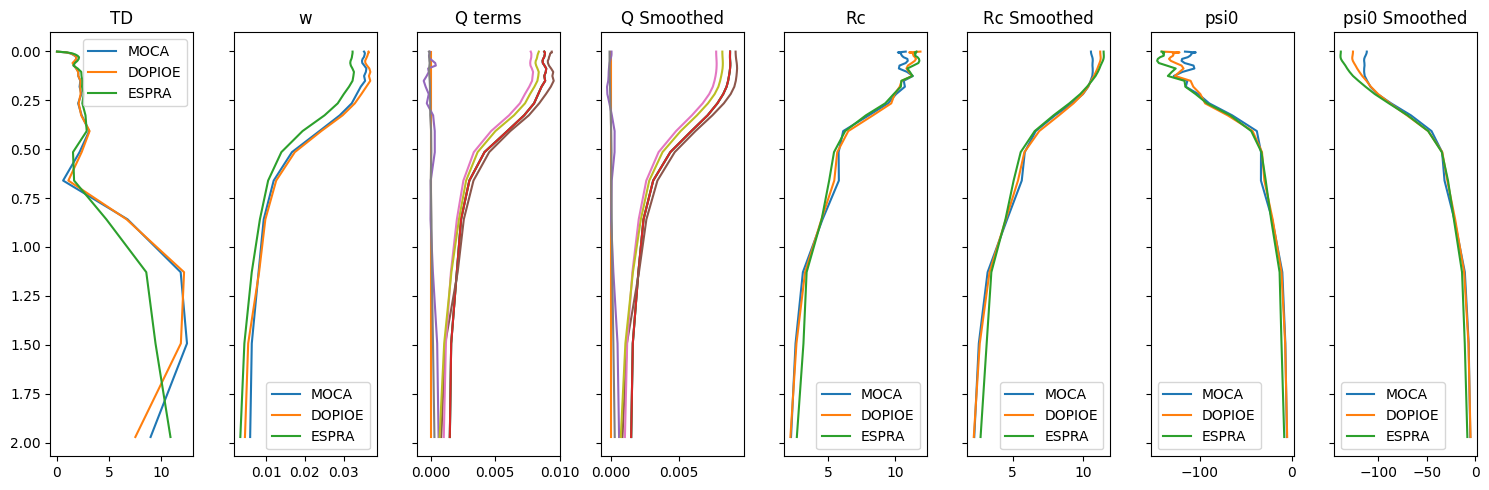

In [4]:
fig, axs = plt.subplots(1, 8, figsize=(15, 5), sharey=True)

df_moc = df_data[df_data['Method'] == 'MOCA'].copy()
z0 = df_moc[df_moc['z'] == 0].iloc[0]
df_moc['TD'] = np.hypot(df_moc['xc'] - z0['xc'], df_moc['yc'] - z0['yc'])
df_moc['sRc'] = smooth(df_moc['Rc'], df_moc['Depth'])
df_moc['spsi0'] = smooth(df_moc['psi0'], df_moc['Depth'])
sq11 = smooth(df_moc['Q'].apply(lambda q: q[0,0]), df_moc['Depth'])
sq12 = smooth(df_moc['Q'].apply(lambda q: q[0,1]), df_moc['Depth'])
sq22 = smooth(df_moc['Q'].apply(lambda q: q[1,1]), df_moc['Depth'])
sQ = []
for q11, q12, q22 in zip(sq11, sq12, sq22):
    sQ.append(np.array([[q11, q12], [q12, q22]]))
df_moc['sQ'] = sQ
              
df_dop = df_data[df_data['Method'] == 'DOPIOE'].copy()
z0 = df_dop[df_dop['z'] == 0].iloc[0]
df_dop['TD'] = np.hypot(df_dop['xc'] - z0['xc'], df_dop['yc'] - z0['yc'])
df_dop['sRc'] = smooth(df_dop['Rc'], df_dop['Depth'])
df_dop['spsi0'] = smooth(df_dop['psi0'], df_dop['Depth'])
sq11 = smooth(df_dop['Q'].apply(lambda q: q[0,0]), df_dop['Depth'])
sq12 = smooth(df_dop['Q'].apply(lambda q: q[0,1]), df_dop['Depth'])
sq22 = smooth(df_dop['Q'].apply(lambda q: q[1,1]), df_dop['Depth'])
sQ = []
for q11, q12, q22 in zip(sq11, sq12, sq22):
    sQ.append(np.array([[q11, q12], [q12, q22]]))
df_dop['sQ'] = sQ

df_esp = df_data[df_data['Method'] == 'ESPRA'].copy()
z0 = df_esp[df_esp['z'] == 0].iloc[0]
df_esp['TD'] = np.hypot(df_esp['xc'] - z0['xc'], df_esp['yc'] - z0['yc'])
df_esp['sRc'] = smooth(df_esp['Rc'], df_esp['Depth'])
df_esp['spsi0'] = smooth(df_esp['psi0'], df_esp['Depth'])
sq11 = smooth(df_esp['Q'].apply(lambda q: q[0,0]), df_esp['Depth'])
sq12 = smooth(df_esp['Q'].apply(lambda q: q[0,1]), df_esp['Depth'])
sq22 = smooth(df_esp['Q'].apply(lambda q: q[1,1]), df_esp['Depth'])
sQ = []
for q11, q12, q22 in zip(sq11, sq12, sq22):
    sQ.append(np.array([[q11, q12], [q12, q22]]))
df_esp['sQ'] = sQ

axs[0].plot(df_moc['TD'], df_moc['Depth'], label='MOCA')
axs[0].plot(df_dop['TD'], df_dop['Depth'], label='DOPIOE')
axs[0].plot(df_esp['TD'], df_esp['Depth'], label='ESPRA')
axs[0].set_title('TD')

axs[1].plot(df_moc['w'], df_moc['Depth'], label='MOCA')
axs[1].plot(df_dop['w'], df_dop['Depth'], label='DOPIOE')
axs[1].plot(df_esp['w'], df_esp['Depth'], label='ESPRA')
axs[1].set_title('w')

axs[2].plot(df_moc['Q'].apply(lambda q: q[0, 0]), df_moc['Depth'], label='q11 MOCA')
axs[2].plot(df_moc['Q'].apply(lambda q: q[0, 1]), df_moc['Depth'], label='q12 MOCA')
axs[2].plot(df_moc['Q'].apply(lambda q: q[1, 1]), df_moc['Depth'], label='q22 MOCA')
axs[2].plot(df_dop['Q'].apply(lambda q: q[0, 0]), df_dop['Depth'], label='q11 DOPIOE')
axs[2].plot(df_dop['Q'].apply(lambda q: q[0, 1]), df_dop['Depth'], label='q12 DOPIOE')
axs[2].plot(df_dop['Q'].apply(lambda q: q[1, 1]), df_dop['Depth'], label='q22 DOPIOE')
axs[2].plot(df_esp['Q'].apply(lambda q: q[0, 0]), df_esp['Depth'], label='q11 ESPRA')
axs[2].plot(df_esp['Q'].apply(lambda q: q[0, 1]), df_esp['Depth'], label='q12 ESPRA')
axs[2].plot(df_esp['Q'].apply(lambda q: q[1, 1]), df_esp['Depth'], label='q22 ESPRA')
axs[2].set_title('Q terms')

axs[3].plot(df_moc['sQ'].apply(lambda q: q[0, 0]), df_moc['Depth'], label='q11 MOCA')
axs[3].plot(df_moc['sQ'].apply(lambda q: q[0, 1]), df_moc['Depth'], label='q12 MOCA')
axs[3].plot(df_moc['sQ'].apply(lambda q: q[1, 1]), df_moc['Depth'], label='q22 MOCA')
axs[3].plot(df_dop['sQ'].apply(lambda q: q[0, 0]), df_dop['Depth'], label='q11 DOPIOE')
axs[3].plot(df_dop['sQ'].apply(lambda q: q[0, 1]), df_dop['Depth'], label='q12 DOPIOE')
axs[3].plot(df_dop['sQ'].apply(lambda q: q[1, 1]), df_dop['Depth'], label='q22 DOPIOE')
axs[3].plot(df_esp['sQ'].apply(lambda q: q[0, 0]), df_esp['Depth'], label='q11 ESPRA')
axs[3].plot(df_esp['sQ'].apply(lambda q: q[0, 1]), df_esp['Depth'], label='q12 ESPRA')
axs[3].plot(df_esp['sQ'].apply(lambda q: q[1, 1]), df_esp['Depth'], label='q22 ESPRA')
axs[3].set_title('Q Smoothed')

axs[4].plot(df_moc['Rc'], df_moc['Depth'], label='MOCA')
axs[4].plot(df_dop['Rc'], df_dop['Depth'], label='DOPIOE')
axs[4].plot(df_esp['Rc'], df_esp['Depth'], label='ESPRA')
axs[4].set_title('Rc')

axs[5].plot(df_moc['sRc'], df_moc['Depth'], label='MOCA')
axs[5].plot(df_dop['sRc'], df_dop['Depth'], label='DOPIOE')
axs[5].plot(df_esp['sRc'], df_esp['Depth'], label='ESPRA')
axs[5].set_title('Rc Smoothed')

axs[6].plot(df_moc['psi0'], df_moc['Depth'], label='MOCA')
axs[6].plot(df_dop['psi0'], df_dop['Depth'], label='DOPIOE')
axs[6].plot(df_esp['psi0'], df_esp['Depth'], label='ESPRA')
axs[6].set_title('psi0')

axs[7].plot(df_moc['spsi0'], df_moc['Depth'], label='MOCA')
axs[7].plot(df_dop['spsi0'], df_dop['Depth'], label='DOPIOE')
axs[7].plot(df_esp['spsi0'], df_esp['Depth'], label='ESPRA')
axs[7].set_title('psi0 Smoothed')

for a, ax in enumerate(axs):
    if a not in [2, 3]:
        ax.legend()
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()


In [5]:
U_moc, V_moc = np.zeros((X.shape[0], X.shape[1], len(df_moc))), np.zeros((X.shape[0], X.shape[1], len(df_moc)))
for kk, k in enumerate(df_moc['z'].unique()):
    row_moc = df_moc[df_moc['z'] == k].iloc[0]
    x0_moc, y0_moc, Q_moc, Rc_moc, psi0_moc = row_moc['xc'], row_moc['yc'], row_moc['Q'], row_moc['sRc'], row_moc['psi0']
    u_moc, v_moc, X_moc, Y_moc = gaussian_vel_reconstruction(x0_moc, y0_moc, Q_moc[0,0], Q_moc[1,0], Q_moc[1,1], Rc_moc, psi0_moc, X, Y)
    U_moc[:,:,kk] = u_moc
    V_moc[:,:,kk] = v_moc
U_dop, V_dop = np.zeros((X.shape[0], X.shape[1], len(df_dop))), np.zeros((X.shape[0], X.shape[1], len(df_dop)))
for kk, k in enumerate(df_dop['z'].unique()):
    row_dop = df_dop[df_dop['z'] == k].iloc[0]
    x0_dop, y0_dop, Q_dop, Rc_dop, psi0_dop = row_dop['xc'], row_dop['yc'], row_dop['Q'], row_dop['sRc'], row_dop['psi0']
    u_dop, v_dop, X_dop, Y_dop = gaussian_vel_reconstruction(x0_dop, y0_dop, Q_dop[0,0], Q_dop[1,0], Q_dop[1,1], Rc_dop, psi0_dop, X, Y)
    U_dop[:,:,kk] = u_dop
    V_dop[:,:,kk] = v_dop
V_esp, U_esp= np.zeros((X.shape[0], X.shape[1], len(df_esp))), np.zeros((X.shape[0], X.shape[1], len(df_esp)))
for kk, k in enumerate(df_esp['z'].unique()):
    row_esp = df_esp[df_esp['z'] == k].iloc[0]
    x0_esp, y0_esp, Q_esp, Rc_esp, psi0_esp = row_esp['xc'], row_esp['yc'], row_esp['Q'], row_esp['sRc'], row_esp['psi0']
    u_esp, v_esp, X_esp, Y_esp = gaussian_vel_reconstruction(x0_esp, y0_esp, Q_esp[0,0], Q_esp[1,0], Q_esp[1,1], Rc_esp, psi0_esp, X, Y)
    U_esp[:,:,kk] = u_esp
    V_esp[:,:,kk] = v_esp

def compute_vorticity(X, Y, U, V):
    
    dx = np.gradient(X, axis=0)[0,0]
    dy = np.gradient(Y, axis=1)[0,0]
    dzeta = []

    for k in range(U.shape[2]):
        dVdx = np.gradient(V[:, :, k], dx, axis=0)
        dUdy = np.gradient(U[:, :, k], dy, axis=1)
        dzeta.append(dVdx - dUdy)

    return np.stack(dzeta, axis=2)  # shape: (nx, ny, nz)

vort = compute_vorticity(X, Y, U, V)
vort_moc = compute_vorticity(X, Y, U_moc, V_moc)
vort_dop = compute_vorticity(X, Y, U_dop, V_dop)
vort_esp = compute_vorticity(X, Y, U_esp, V_esp)

dic = {
    'ORIG': {'z': z, 'U': U, 'V': V, 'Vort': vort},
    'MOCA': {'z': df_moc['Depth'], 'U': U_moc, 'V': V_moc, 'Vort': vort_moc, 'df': df_moc, 'c': 'b'},
    'DOPIOE': {'z': df_dop['Depth'], 'U': U_dop, 'V': V_dop,  'Vort': vort_dop, 'df': df_dop, 'c': 'orangered'},
    'ESPRA': {'z': df_esp['Depth'], 'U': U_esp, 'V': V_esp, 'Vort': vort_esp, 'df': df_esp, 'c': 'g'},
}


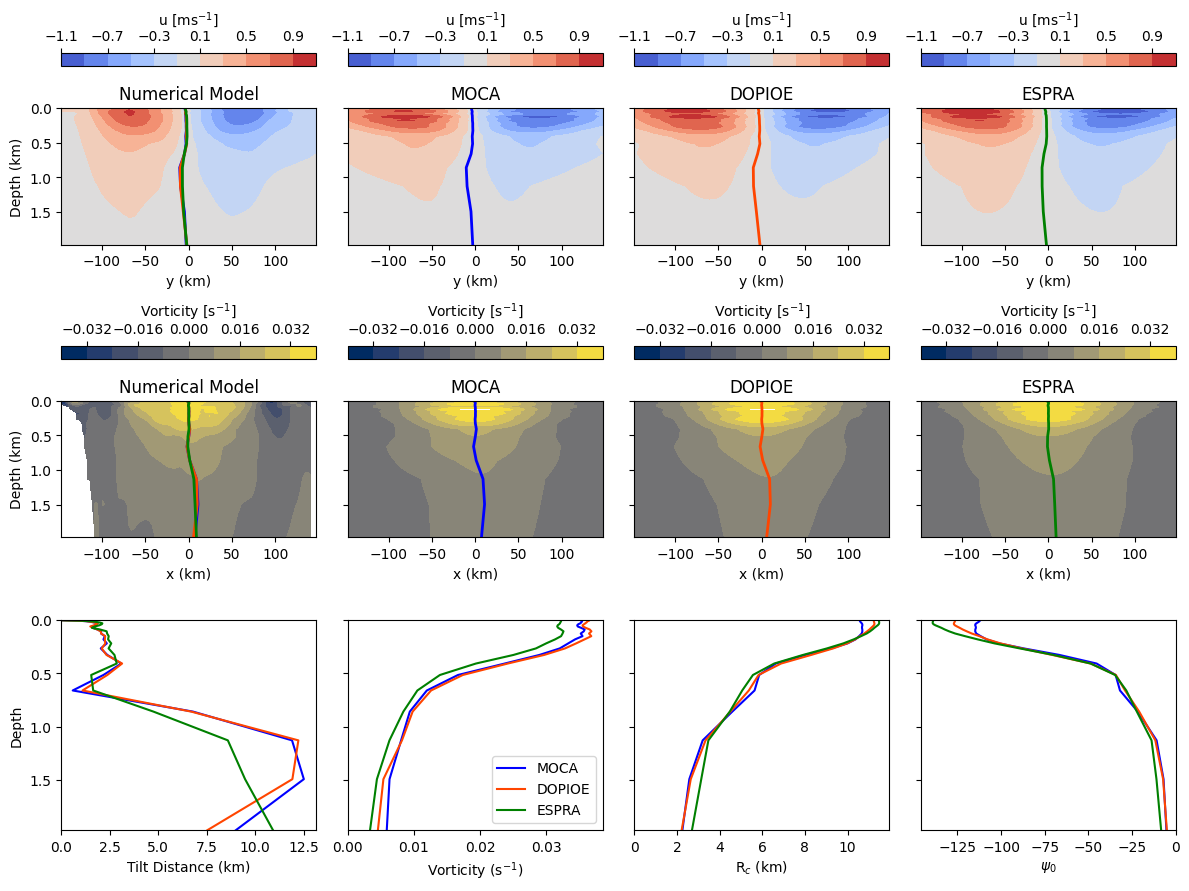

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig, axs = plt.subplots(3, 4, figsize=(12, 9), sharey=True)

zmin = min(d['z'].max() for d in dic.values())
vabs_uv = 1.1
vabs_vort = .04
# Create exactly 15 evenly spaced levels from -1 to +1:
levels_uv = np.linspace(-vabs_uv, vabs_uv, 12)
levels_vort = np.linspace(-vabs_vort, vabs_vort, 11)

for k, d in enumerate(dic.values()):
    key = list(dic.keys())[k]
    mask = d['z'] <= zmin

    # Top row: V over x
    ax = axs[1, k]
    j = X.shape[1] // 2

    cf1 = ax.contourf(
        x,
        d['z'][mask],
        d['Vort'][:, j, mask].T,
        levels=levels_vort,         # ← explicitly give the array of levels
        cmap='cividis',
        vmin=-vabs_vort, vmax=vabs_vort     # ← still helps Matplotlib know the min/max
    )
    ax.invert_yaxis()
    c1 = fig.colorbar(
        cf1,
        ax=ax,
        orientation='horizontal',
        pad=0.2,
        location='top',
        label=r'Vorticity [s$^{-1}$]'
    )
    c1.ax.xaxis.set_ticks_position('top')
    c1.ax.xaxis.set_label_position('top')

    ax.set_xlabel('x (km)')
    if k == 0:
        ax.set_ylabel('Depth (km)')
    ax.set_ylim(zmin, 0)
    ax.set_title(key if key != 'ORIG' else 'Numerical Model')

    if key != 'ORIG':
        df = d['df']
        ax.plot(df['xc'], df['Depth'], color=d['c'], label=key, linewidth=2)
        axs[1, 0].plot(df['xc'], df['Depth'], color=d['c'], label=key, linewidth=2)

    # Bottom row: U over y
    ax = axs[0, k]
    i = X.shape[0] // 2

    cf2 = ax.contourf(
        y,
        d['z'][mask],
        d['U'][i, :, mask],
        levels=levels_uv,         # ← same idea here
        cmap='coolwarm',
        vmin=-vabs_uv, vmax=vabs_uv
    )
    ax.invert_yaxis()
    c2 = fig.colorbar(
        cf2,
        ax=ax,
        orientation='horizontal',
        pad=0.2,
        location='top',
        label=r'u [ms$^{-1}$]'
    )
    c2.ax.xaxis.set_ticks_position('top')
    c2.ax.xaxis.set_label_position('top')

    ax.set_xlabel('y (km)')
    if k == 0:
        ax.set_ylabel('Depth (km)')
    ax.set_ylim(zmin, 0)
    ax.set_title(key if key != 'ORIG' else 'Numerical Model')

    if key != 'ORIG':
        df = d['df']
        ax.plot(df['yc'], df['Depth'], color=d['c'], label=key, linewidth=2)
        axs[0, 0].plot(df['yc'], df['Depth'], color=d['c'], label=key, linewidth=2)


axs[2,0].plot(df_moc['TD'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[2,0].plot(df_dop['TD'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[2,0].plot(df_esp['TD'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[2,0].set_ylabel('Depth')
axs[2,0].set_xlabel('Tilt Distance (km)')
axs[2,0].set_xlim(0,None)

axs[2,1].plot(df_moc['w'], df_moc['Depth'], label='MOCA',c=dic['MOCA']['c'])
axs[2,1].plot(df_dop['w'], df_dop['Depth'], label='DOPIOE', c=dic['DOPIOE']['c'])
axs[2,1].plot(df_esp['w'], df_esp['Depth'], label='ESPRA', c=dic['ESPRA']['c'])
axs[2,1].set_xlabel(r'Vorticity (s$^{-1}$)')
axs[2,1].set_xlim(0,None)
axs[2,1].legend()

axs[2,2].plot(df_moc['sRc'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[2,2].plot(df_dop['sRc'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[2,2].plot(df_esp['sRc'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[2,2].set_xlabel(r'R$_{c}$ (km)')
axs[2,2].set_xlim(0,None)

axs[2,3].plot(df_moc['spsi0'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[2,3].plot(df_dop['spsi0'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[2,3].plot(df_esp['spsi0'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[2,3].set_xlabel(r'$\psi_0$')
axs[2,3].set_xlim(None,0)

plt.tight_layout()
plt.show()


#### Vertical Flow

In [7]:
def interpolate_to_regular_grid(X, Y, x, y, U, V, z, dx, method='linear'):
    from scipy.interpolate import RegularGridInterpolator
    new_x = np.arange(x.min(), x.max(), dx)
    new_y = np.arange(y.min(), y.max(), dx)
    new_z = np.linspace(z.min(), z.max(), len(z))
    rgi_u = RegularGridInterpolator((x, y, z), U, method=method, bounds_error=False, fill_value=np.nan)
    rgi_v = RegularGridInterpolator((x, y, z), V, method=method, bounds_error=False, fill_value=np.nan)
    xx, yy, zz = np.meshgrid(new_x, new_y, new_z, indexing='ij')
    pts = np.stack((xx, yy, zz), axis=-1)
    Un = rgi_u(pts)
    Vn = rgi_v(pts)
    Xn, Yn = np.meshgrid(new_x, new_y, indexing='ij')
    return Xn, Yn, new_z, Un, Vn
    

In [8]:
dic_omega = {'ORIG': {}, 'MOCA': {}, 'DOPIOE': {}, 'ESPRA': {}}
for k, d in enumerate(dic.values()):
    key = list(dic.keys())[k]
    Xn, Yn, zn, Un, Vn = interpolate_to_regular_grid(X, Y, x, y, d['U'], d['V'], d['z']*1000, dx=10)
    xn, yn = Xn[:,0], Yn[0,:]
    w = solve_w(np.where(np.isnan(Un), 0, Un), np.where(np.isnan(Vn), 0, Vn), xn, yn, zn)
    dic_omega[key] = {'X': Xn, 'Y': Yn, 'x': xn, 'y': yn, 'z': zn, 'w': w}


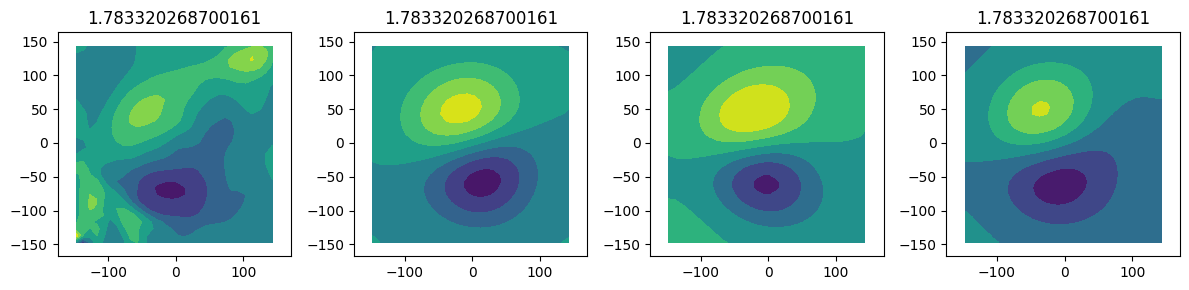

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(12,3))
dep_lvl = 0
for k, d in enumerate(dic_omega.values()):
    key = list(dic.keys())[k]
    Xn, Yn, xn, yn, zn, w = d['X'], d['Y'], d['x'], d['y'], d['z'], d['w']
    axs[k].contourf(Xn, Yn, w[:, :, dep_lvl])
    axs[k].set_title(z[dep_lvl]*1000)
    axs[k].axis('equal')
plt.tight_layout()


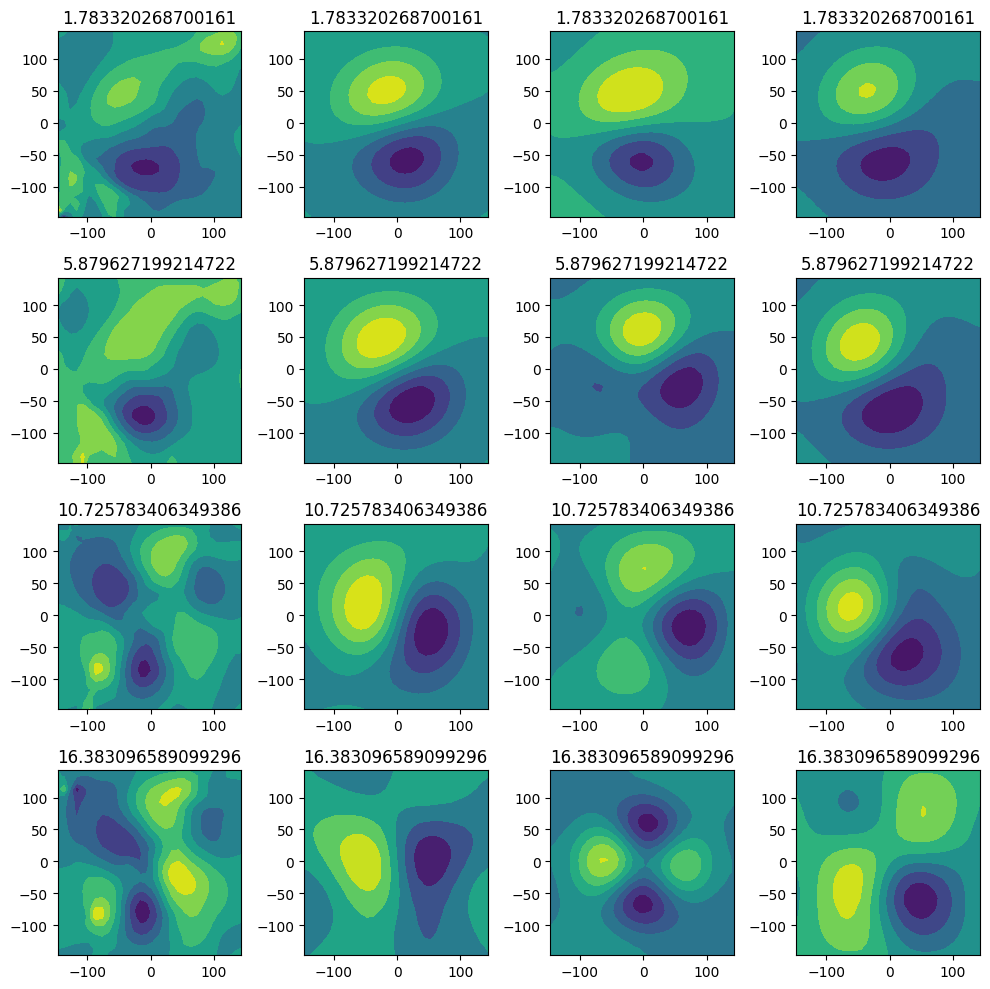

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(10,10))
depth_lvls = [0, 1, 2, 3]
for k, d in enumerate(dic_omega.values()):
    key = list(dic.keys())[k]
    Xn, Yn, xn, yn, zn, w = d['X'], d['Y'], d['x'], d['y'], d['z'], d['w']
    for p, dep_lvl in enumerate(depth_lvls):
        axs[p,k].contourf(Xn, Yn, w[:, :, dep_lvl])
        axs[p,k].set_title(z[dep_lvl]*1000)
plt.tight_layout()


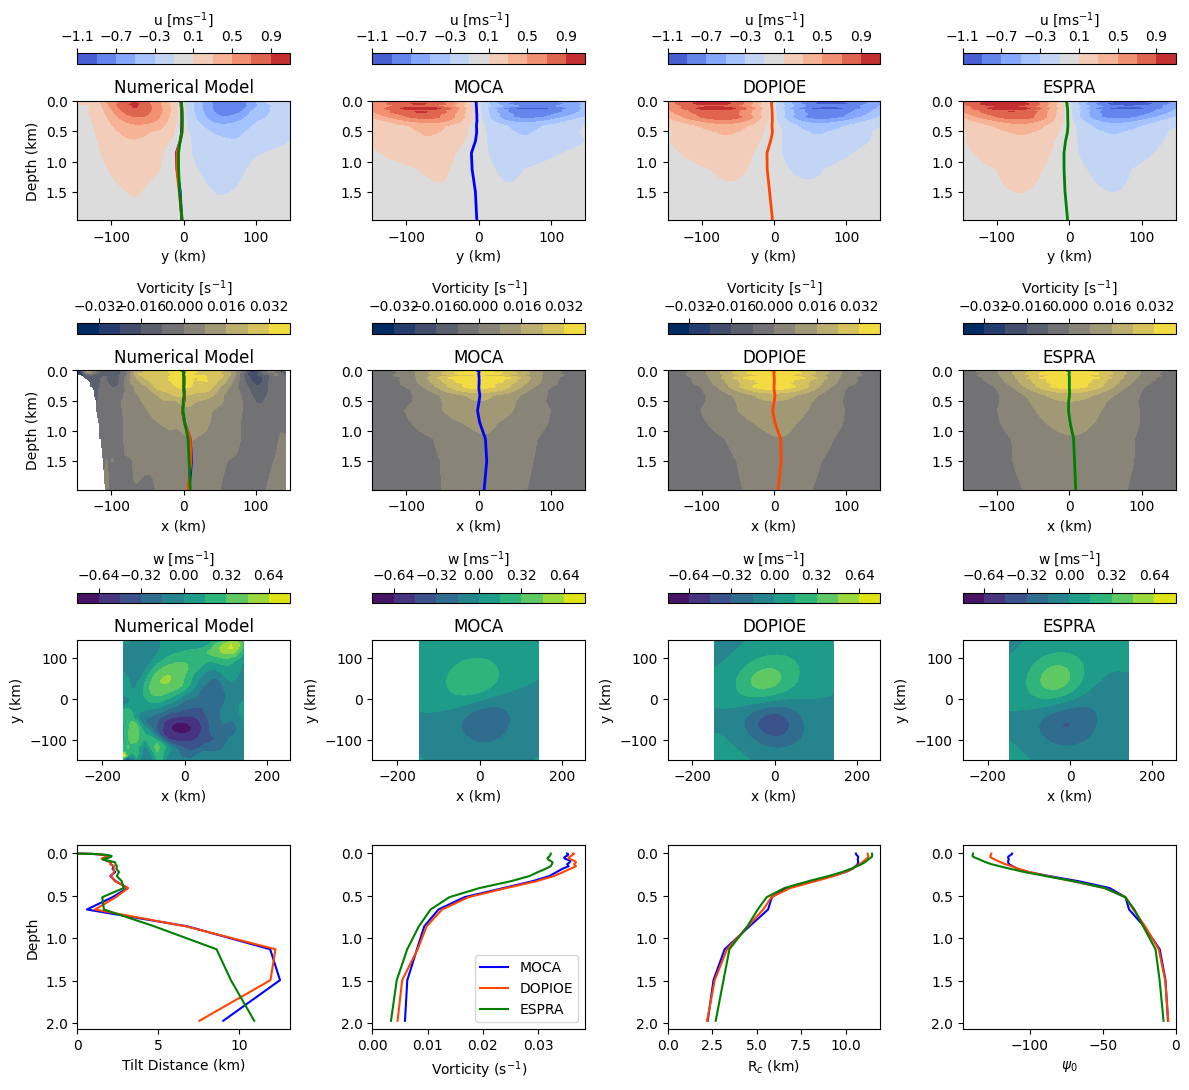

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig, axs = plt.subplots(4, 4, figsize=(12, 11))

zmin = min(d['z'].max() for d in dic.values())
vabs_uv = 1.1
vabs_vort = .04
# Create exactly 15 evenly spaced levels from -1 to +1:
levels_uv = np.linspace(-vabs_uv, vabs_uv, 12)
levels_vort = np.linspace(-vabs_vort, vabs_vort, 11)

for k, d in enumerate(dic.values()):
    key = list(dic.keys())[k]
    mask = d['z'] <= zmin

    # Top row: V over x
    ax = axs[1, k]
    j = X.shape[1] // 2

    cf1 = ax.contourf(
        x,
        d['z'][mask],
        d['Vort'][:, j, mask].T,
        levels=levels_vort,         # ← explicitly give the array of levels
        cmap='cividis',
        vmin=-vabs_vort, vmax=vabs_vort     # ← still helps Matplotlib know the min/max
    )
    ax.invert_yaxis()
    c1 = fig.colorbar(
        cf1,
        ax=ax,
        orientation='horizontal',
        pad=0.2,
        location='top',
        label=r'Vorticity [s$^{-1}$]'
    )
    c1.ax.xaxis.set_ticks_position('top')
    c1.ax.xaxis.set_label_position('top')

    ax.set_xlabel('x (km)')
    if k == 0:
        ax.set_ylabel('Depth (km)')
    ax.set_ylim(zmin, 0)
    ax.set_title(key if key != 'ORIG' else 'Numerical Model')

    if key != 'ORIG':
        df = d['df']
        ax.plot(df['xc'], df['Depth'], color=d['c'], label=key, linewidth=2)
        axs[1, 0].plot(df['xc'], df['Depth'], color=d['c'], label=key, linewidth=2)

    # Bottom row: U over y
    ax = axs[0, k]
    i = X.shape[0] // 2

    cf2 = ax.contourf(
        y,
        d['z'][mask],
        d['U'][i, :, mask],
        levels=levels_uv,         # ← same idea here
        cmap='coolwarm',
        vmin=-vabs_uv, vmax=vabs_uv
    )
    ax.invert_yaxis()
    c2 = fig.colorbar(
        cf2,
        ax=ax,
        orientation='horizontal',
        pad=0.2,
        location='top',
        label=r'u [ms$^{-1}$]'
    )
    c2.ax.xaxis.set_ticks_position('top')
    c2.ax.xaxis.set_label_position('top')

    ax.set_xlabel('y (km)')
    if k == 0:
        ax.set_ylabel('Depth (km)')
    ax.set_ylim(zmin, 0)
    ax.set_title(key if key != 'ORIG' else 'Numerical Model')

    if key != 'ORIG':
        df = d['df']
        ax.plot(df['yc'], df['Depth'], color=d['c'], label=key, linewidth=2)
        axs[0, 0].plot(df['yc'], df['Depth'], color=d['c'], label=key, linewidth=2)

dep_lvl = 0
vabs = .8
levels = np.linspace(-vabs, vabs, 11)
for k, d in enumerate(dic_omega.values()):
    key = list(dic.keys())[k]
    Xn, Yn, xn, yn, zn, w = d['X'], d['Y'], d['x'], d['y'], d['z'], d['w']
    cf = axs[2,k].contourf(Xn, Yn, w[:, :, dep_lvl]*86400, levels=levels)
    axs[2,k].set_title(z[dep_lvl]*1000)
    axs[2,k].set_title(key if key != 'ORIG' else 'Numerical Model')
    c = fig.colorbar(
    cf,
    ax=axs[2,k],
    orientation='horizontal',
    pad=0.2,
    location='top',
    label=r'w [ms$^{-1}$]'
    )
    c.ax.xaxis.set_ticks_position('top')
    c.ax.xaxis.set_label_position('top')
    axs[2,k].set_xlabel('x (km)')
    axs[2,k].set_ylabel('y (km)')
    axs[2,k].axis('equal')
    

axs[3,0].plot(df_moc['TD'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[3,0].plot(df_dop['TD'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[3,0].plot(df_esp['TD'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[3,0].set_ylabel('Depth')
axs[3,0].set_xlabel('Tilt Distance (km)')
axs[3,0].set_xlim(0,None)
axs[3,0].invert_yaxis()

axs[3,1].plot(df_moc['w'], df_moc['Depth'], label='MOCA',c=dic['MOCA']['c'])
axs[3,1].plot(df_dop['w'], df_dop['Depth'], label='DOPIOE', c=dic['DOPIOE']['c'])
axs[3,1].plot(df_esp['w'], df_esp['Depth'], label='ESPRA', c=dic['ESPRA']['c'])
axs[3,1].set_xlabel(r'Vorticity (s$^{-1}$)')
axs[3,1].set_xlim(0,None)
axs[3,1].legend()
axs[3,1].invert_yaxis()

axs[3,2].plot(df_moc['sRc'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[3,2].plot(df_dop['sRc'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[3,2].plot(df_esp['sRc'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[3,2].set_xlabel(r'R$_{c}$ (km)')
axs[3,2].set_xlim(0,None)
axs[3,2].invert_yaxis()

axs[3,3].plot(df_moc['spsi0'], df_moc['Depth'], c=dic['MOCA']['c'])
axs[3,3].plot(df_dop['spsi0'], df_dop['Depth'], c=dic['DOPIOE']['c'])
axs[3,3].plot(df_esp['spsi0'], df_esp['Depth'], c=dic['ESPRA']['c'])
axs[3,3].set_xlabel(r'$\psi_0$')
axs[3,3].set_xlim(None,0)
axs[3,3].invert_yaxis()

plt.tight_layout()
plt.show()
